In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,  RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report , make_scorer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import StandardScaler
import pickle

In [2]:
df = pd.read_csv("ddos.csv")

In [3]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,6,188912,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
1,6,183,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
2,6,168997,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
3,6,151583,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
4,17,3,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP


# Analyse de Forme :

In [4]:
df[' Label'].value_counts()

LDAP       200000
NetBIOS    200000
MSSQL      200000
UDP        200000
Syn        199997
Portmap    186960
BENIGN      56923
UDPLag       1873
Name:  Label, dtype: int64

Text(0.5, 1.0, 'Class Distributions ')

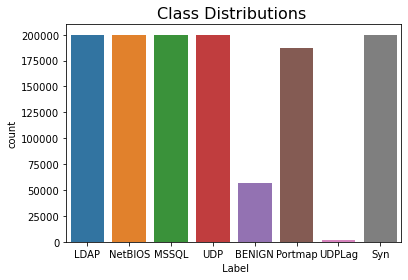

In [5]:
sns.countplot(x=' Label',data=df)
plt.title('Class Distributions ', fontsize=16)


# Preprocessing :

In [6]:
def encodage(df):
    code ={'BENIGN':0, 
       'LDAP': 1,
       'NetBIOS':2,
       'MSSQL':3,
       'UDP':4,
       'Portmap':2,
       'UDPLag':5,
       'Syn':6
       }
    
    df[' Label'] = df[' Label'].map(code)
   
    return df



In [7]:
df = encodage(df)   
y = df[' Label'] 
X= df.drop(' Label', axis=1)

In [8]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros= ros.fit_resample(X, y)
y_ros.value_counts()


1    386960
2    386960
3    386960
4    386960
0    386960
5    386960
6    386960
Name:  Label, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=4)

In [10]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)


# Modellisation :

In [11]:
#Voting

voting  = VotingClassifier([('GNB', GaussianNB()),
                            ('Tree', DecisionTreeClassifier(random_state=0)),
                            ('KNN', KNeighborsClassifier())],
                           voting='hard',n_jobs=-1)


#Bagging
bagging = BaggingClassifier(base_estimator=KNeighborsClassifier())
RandomForest = RandomForestClassifier(n_estimators=100,random_state=0)


#Boosting 
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier())
GradBoost = GradientBoostingClassifier(random_state=0)
XGBC= XGBClassifier()
LGBM = LGBMClassifier()
CatBC = CatBoostClassifier()
hist = HistGradientBoostingClassifier()
#lpboost = AdaBoostClassifier(base_estimator=LogisticRegression())


#Stacking
Stack = StackingClassifier([('GNB', GaussianNB()),
                            ('Tree', DecisionTreeClassifier(random_state=0)),
                            ('KNN', KNeighborsClassifier())],
                           final_estimator=KNeighborsClassifier())

In [12]:

dict_of_models = {
                  'voting' : voting,
                  'bagging' : bagging,
                  'RandomForest': RandomForest,
                  'GradBoost' :GradBoost,
                  'XGBClassifier' : XGBC,
                  'LGBM' : LGBM,
                  'CatBC' : CatBC,         
                  'AdaBoost' : AdaBoost,
                  'lpboost' : lpboost,
                  'hist' : hist,
                  'stack' : Stack
                  }


# Procédure d'évaluation :

In [13]:

def evaluation_valid(model,name=None):
    if name is None:
        name = model.__class__.__name__

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    

    with open('model_'+name+'.pkl', 'rb') as f:
        model = pickle.load(f)

    # Make predictions on validation data (X_val)
    ypred = model.predict(X_test)

    # f1-score
    f1 = f1_score(y_test, ypred, average='micro')
    print(f" f1-Score: {f1}")

    # plot confusion matrix for validation set
    cf_matrix = confusion_matrix(y_test, ypred)
    sns.heatmap(cf_matrix, annot=True, fmt=".0f", ax=axes[0])
    axes[0].set_title(f"{name} Confusion Matrix (Validation Set)")

    # plot classification report for validation set
    report = classification_report(y_test, ypred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df, annot=True, cmap='Blues', ax=axes[1])
    axes[1].set_title(f"{name} Classification Report (Validation Set)")

    # plot normalized confusion matrix for validation set
    cm_normalized = cf_matrix / np.sum(cf_matrix, axis=1).reshape(-1, 1)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=axes[2])
    axes[2].set_title(f"{name} Normalized Confusion Matrix (Validation Set)")

    plt.show()



 f1-Score: 0.989925130689034


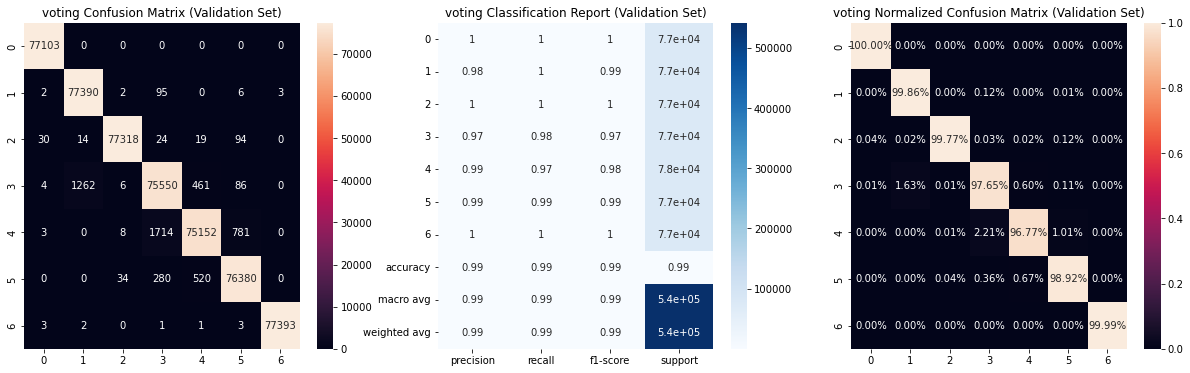

 f1-Score: 0.9913169319826338


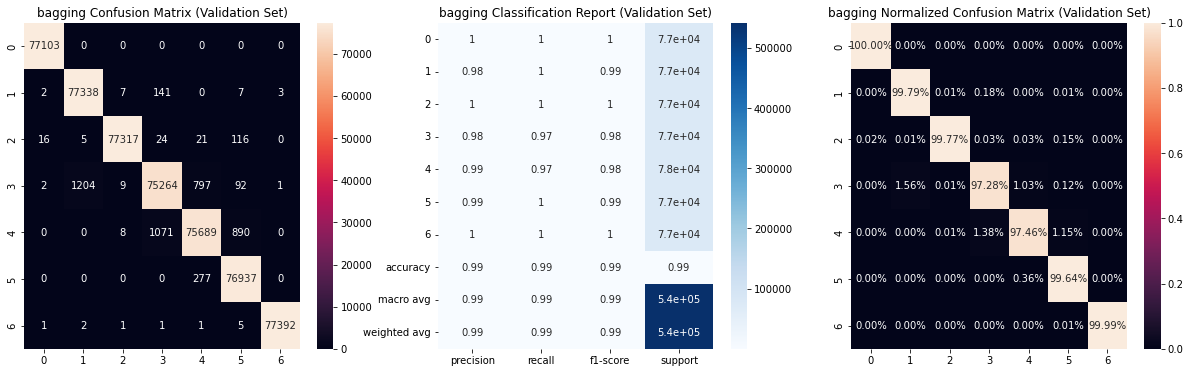

 f1-Score: 0.9896703978262795


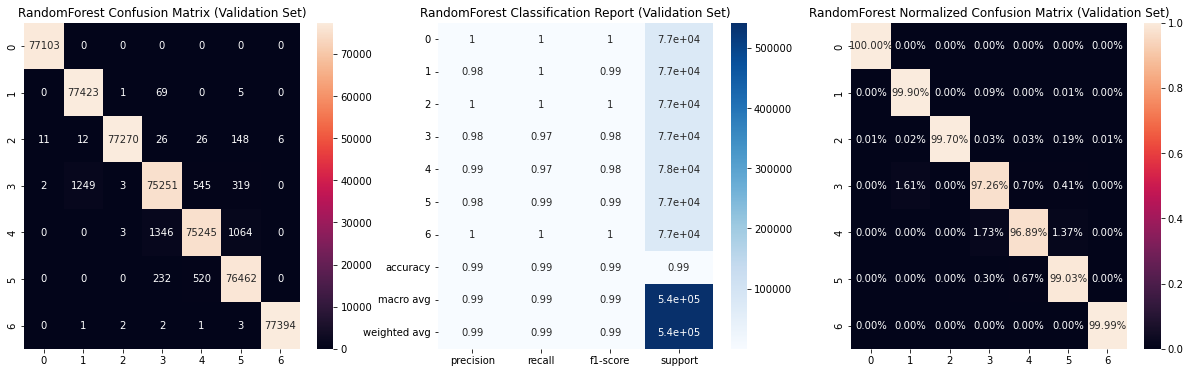

 f1-Score: 0.9872024424820579


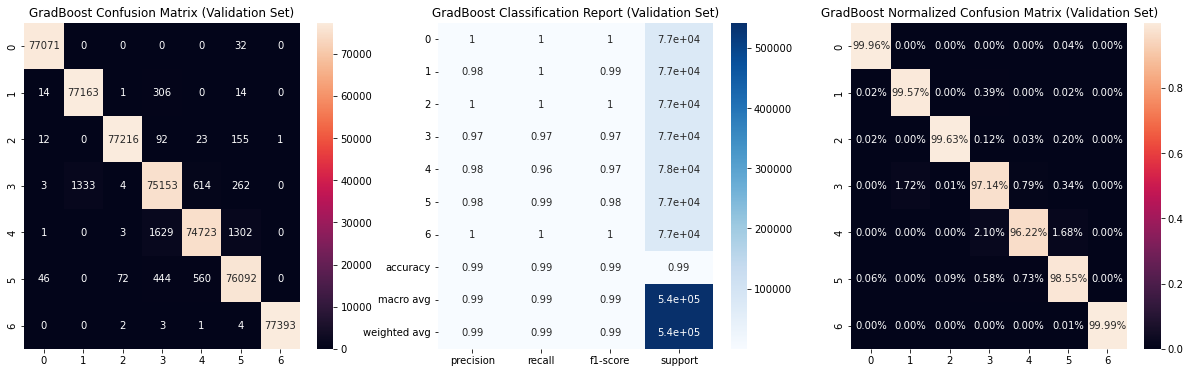

 f1-Score: 0.9917507162054402


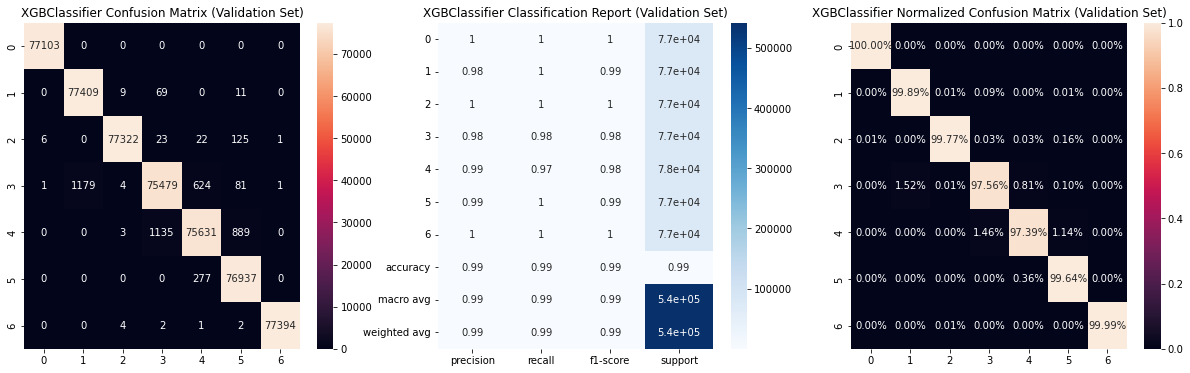

 f1-Score: 0.985225493960247


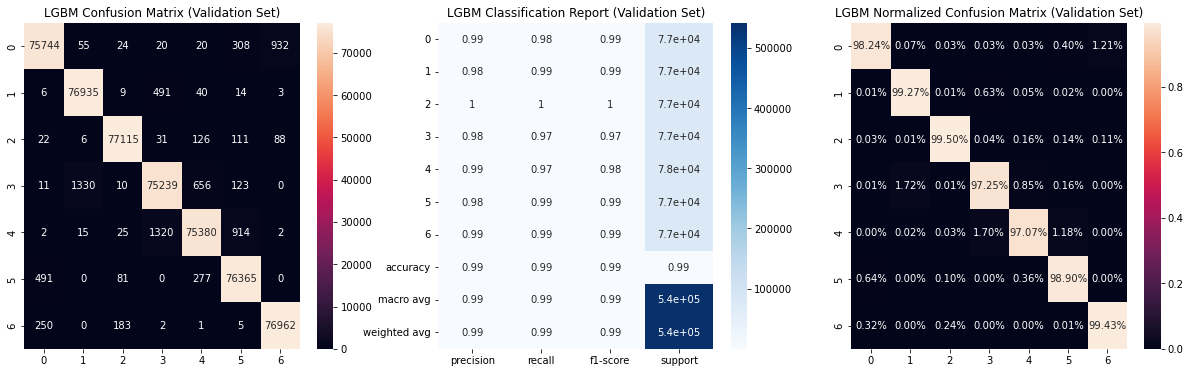

 f1-Score: 0.990510277917245


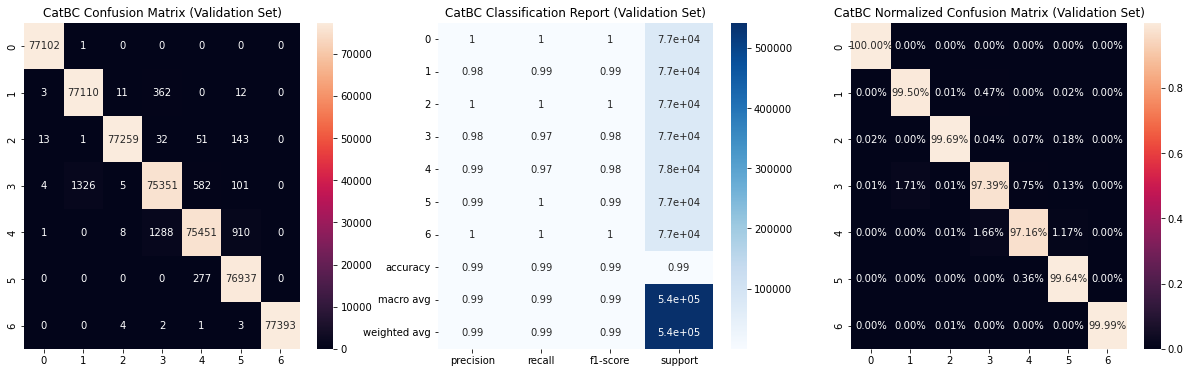

 f1-Score: 0.9897239286452642


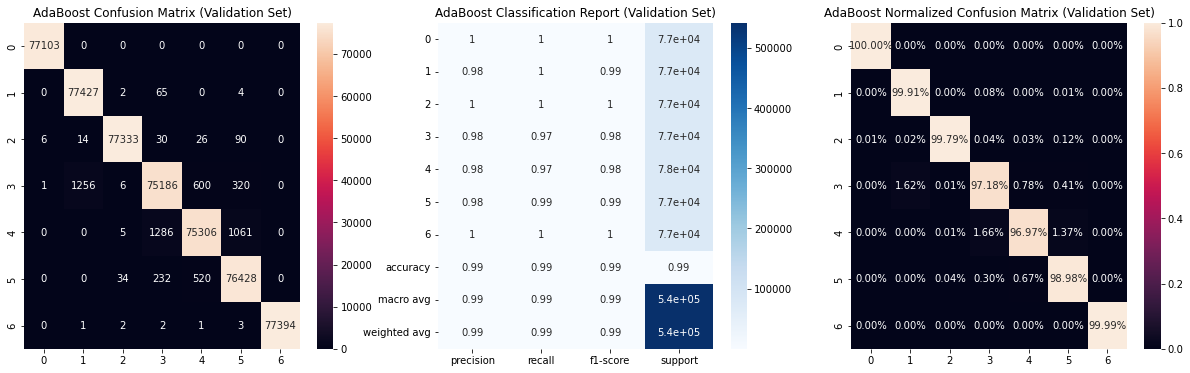

 f1-Score: 0.6897815204229304


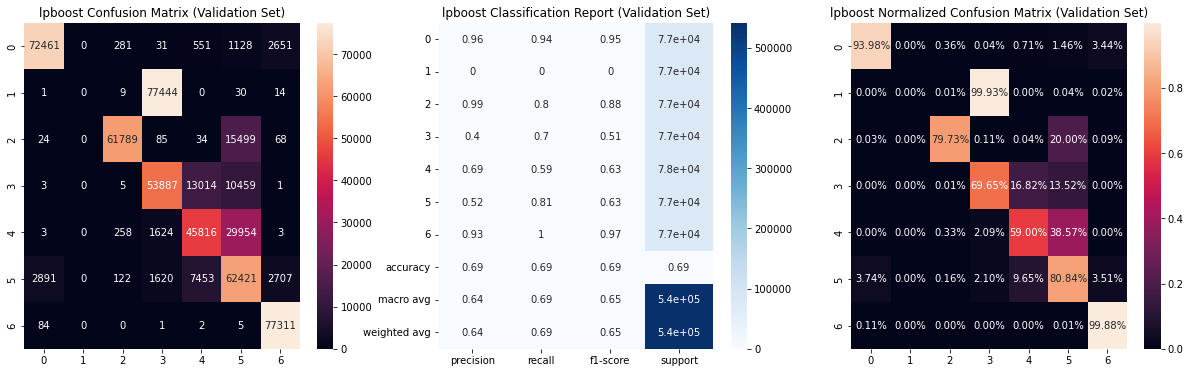

 f1-Score: 0.990172479990549


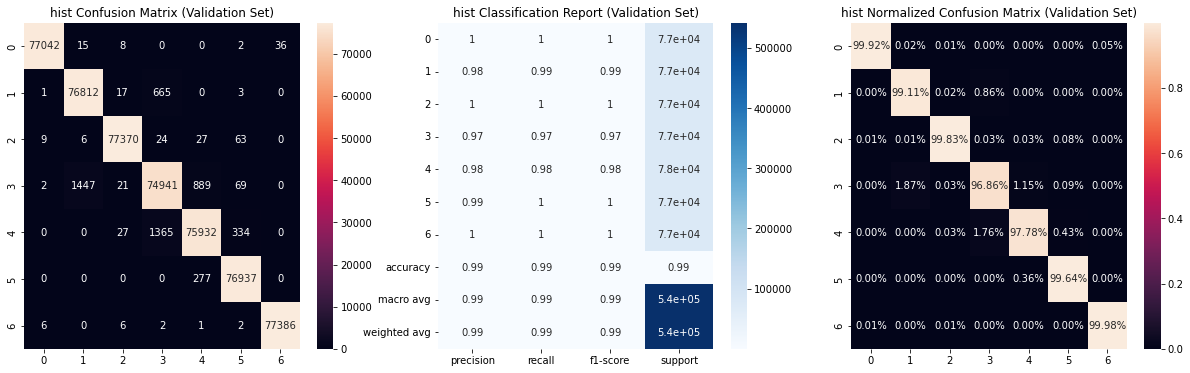

 f1-Score: 0.967019477834549


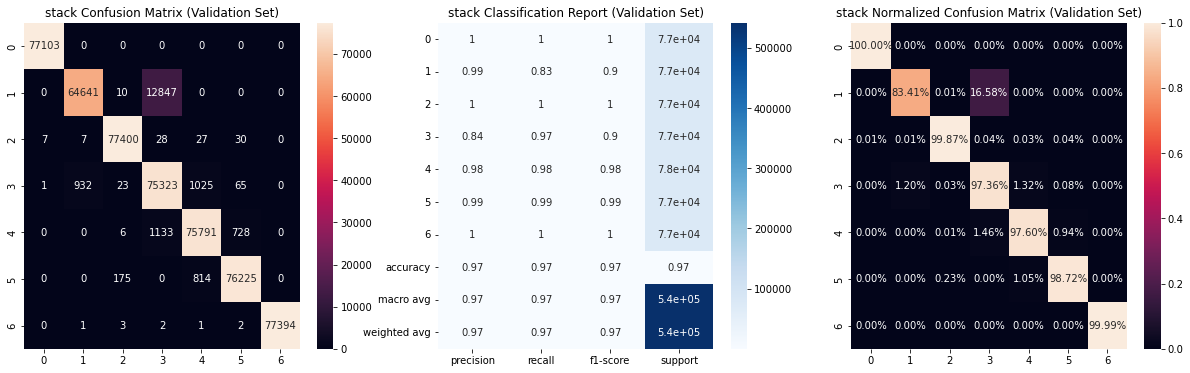

In [14]:
# Iterate over all models in dict_of_models
for name,model in dict_of_models.items():
    evaluation_valid(model,name)
